In [1]:
# import ulab
# --> maybe an emulated environment with circuit python only might be helpful
#
# https://micropython-ulab.readthedocs.io/en/latest/ulab-intro.html
#
# other stuff...
#
# https://github.com/v923z/micropython-ulab
# https://learn.adafruit.com/ulab-crunch-numbers-fast-with-circuitpython
# https://github.com/v923z/micropython-ulab/issues/323

from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


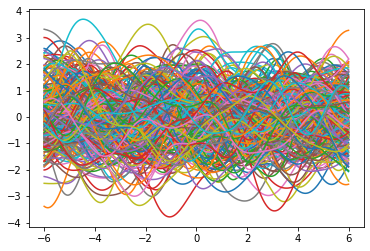

(200, 300)


In [2]:
# different kernel functions

# rbf kernel seems to work best.
# unfortunately "from scipy.spatial.distance import cdist" is not available.
# Instead of implementing whole cdist we might get away with a simpler kernel usin spatial distances.
# Only 2D is possible in circuit python. This makes our lifes easier.
def rbf_kernel(x1, x2, varSigma, lengthscale, noise):
    #x1 = np.squeeze(x1)
    #x2 = np.squeeze(x2)
    if x2 is None:
        d = cdist(x1, x1) # euklidischer abstand sqrt( sum( ( x-xi )**2 ) )
    else:
        d = cdist(x1, x2)
    K = varSigma*np.exp(-np.power(d, 2)/lengthscale)
    return K


# choose index set for the marginal
x = np.linspace(-6, 6, 200).reshape(-1, 1)

# TO DO: kernel working with ulab
# compute covariance matrix
K = rbf_kernel(x, None, 1.0, 2.0, 0)
#K = lin_kernel(x, None, 2.0)
#K = white_kernel(x, None, 2.0)

# create mean vector
mu = np.squeeze(np.zeros(x.shape))
# draw samples 20 from Gaussian distribution
f = np.random.multivariate_normal(mu, K, 300).T
#print(mu)
#print(K)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, f)
plt.show()
plt.close()
print(f.shape)

this is box mueller


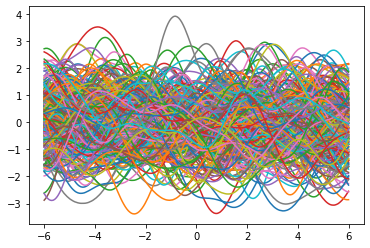

(200, 300)
(200, 1)


In [3]:
# We need to sample from a gaussian distribution. 
# Therefore i implemented box muller 
# should work. Tests below.

import random
import math

def box_muller(dummy,epsilon=0.000001):
    # Avoid getting u == 0.0
    # print("this is box mueller")
    u1, u2 = 0.0, 0.0
    while u1 < epsilon or u2 < epsilon:
        u1 = random.random() #between 0 and 1
        u2 = random.random()
        
    return math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)

def sample_gauss_from_box_mueller(mu,sigma,size):
    print("this is box mueller")
    xx = np.vectorize(box_muller)
    return xx(np.empty(size)) * sigma + mu

def sample_multivariante_normal(mu,K,n,epsilon=0.000001):
    d = len(mu)
    Kx = K + epsilon*np.eye(d)
    L = np.linalg.cholesky(Kx)
    u = sample_gauss_from_box_mueller(0, 1, d*n ).reshape(d, n)
    #u = np.random.normal(loc=0, scale=1, size=d*n).reshape(d, n)
    mu1 = np.array([mu]*n).transpose()#.shape
    return mu1 + np.dot(L, u)

f = sample_multivariante_normal(mu, K, 300)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, f)
plt.show()
plt.close()
print(f.shape)
print(x.shape)

-3.999920488449237 3.999566958444481
this is box mueller
test myfun
0.02045866944522287
0.001041693064290694

 test numpy
0.0005262590822528878
0.0015545959700455914


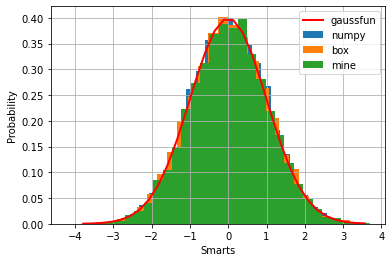

In [4]:
# some tests...

from scipy import special

import sys


def box_muller2():
    # Avoid getting u == 0.0
    u1, u2 = 0.0, 0.0
    while u1 < epsilon or u2 < epsilon:
        u1 = random.random() #between 0 and 1
        u2 = random.random()
        
    n1 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    n2 = math.sqrt(-2 * math.log(u1)) * math.sin(2 * math.pi * u2)
    return n1, n2

N=10000
#random.seed(123)
epsilon = sys.float_info.epsilon
# Use KS to test
samples = [box_muller2()[0] for x in range(N)]

def rand_array(shape):
    fun = lambda x: x*random.uniform(-4, 4)
    xx = np.vectorize(fun)
    return xx(np.ones(shape))

sigma = 1
mu = 0

s = 10000
x = rand_array((200,300))
print(np.min(x),np.max(x))

xx_test = np.random.normal(loc=mu, scale=sigma, size=s)


count, bins, ignored = plt.hist(xx_test, 30, density=True,label="numpy")

#xx = sample_gauss_normal(mu , sigma, s)
#xx = data = np.random.randn(100000) * sigma + mu
xx = sample_gauss_from_box_mueller(mu , sigma, s)


print("test myfun")
print(np.mean(xx) - 0 )
print(np.std(xx) - 1 )

print("\n test numpy")
print(np.mean(xx_test) - 0 )
print(np.std(xx_test) - 1 )

plt.hist(samples, 30, density=True,label="box")
plt.hist(xx, 30, density=True,label="mine")


#n, bins, patches = plt.hist(xx_test,30,alpha=.5,label="test", density=True)
#n, bins, patches = plt.hist(xx,30,alpha=.5,label="myfun",density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r',label="gaussfun")

plt.legend()
plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

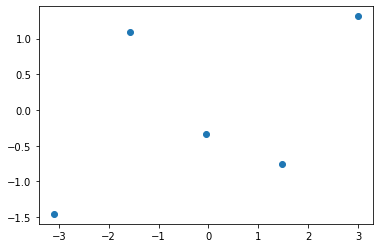

this is box mueller


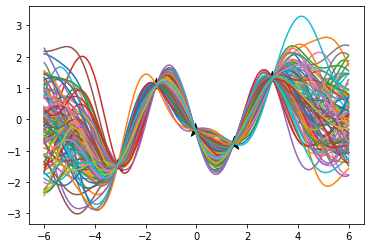

In [10]:
# generate random data points

N = 5
# x,y,x1,y1 have the length N
x = np.linspace(-3.1,3,N)
y = np.sin(2*np.pi/x) + x*0.1 + 0.3*np.random.randn(x.shape[0])
x1 = np.reshape(x,(-1,1))
y1 = np.reshape(y,(-1,1))
# x_star has the length 500...
x_star = np.linspace(-6, 6, 500).reshape(-1, 1)
plt.scatter(x,y)
plt.savefig("gp/exmpl_data.png")
plt.show()

def gp_prediction(x1, y1, xstar, lengthScale, varSigma, noise):
    k_starX = rbf_kernel(xstar,x1,lengthScale,varSigma,noise)
    k_xx = rbf_kernel(x1, None, lengthScale, varSigma, noise)
    k_starstar = rbf_kernel(xstar,None,lengthScale,varSigma,noise)
    mu = k_starX.dot(np.linalg.inv(k_xx)).dot(y1)
    var = k_starstar - (k_starX).dot(np.linalg.inv(k_xx)).dot(k_starX.T)
    return mu, var, xstar

Nsamp = 100
#mu_star, var_star, x_star = gp_prediction(x1, y1, x, lengthScale, varSigma, noise)
mu_star, var_star, x_star = gp_prediction(x1, y1, x_star, 1, 2, 1)
mu_star = np.squeeze(mu_star)
f_star = sample_multivariante_normal(mu_star, var_star, Nsamp)
#f_star = np.random.multivariate_normal(mu_star, var_star, Nsamp)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_star, f_star)
ax.scatter(x1, y1, 200, 'k', '*', zorder=2)

this is box mueller


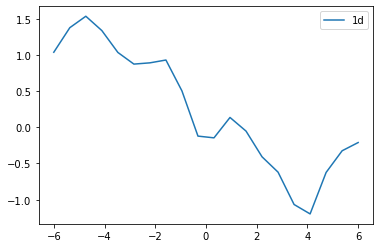

(20,)
(20, 1)


In [6]:
def box_muller_1d(dummy,epsilon=0.000001):
    # Avoid getting u == 0.0
    # print("this is box mueller")
    u1, u2 = 0.0, 0.0
    while u1 < epsilon or u2 < epsilon:
        u1 = random.random() #between 0 and 1
        u2 = random.random()
        
    return math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)

def sample_gauss_box_mueller_1d(mu,sigma,size):
    print("this is box mueller")
    xx = np.vectorize(box_muller_1d)
    return xx(np.empty(size)) * sigma + mu

def sample_multivariante_normal_1d(mu,K,epsilon=0.000001):
    d = len(mu)
    Kx = K + epsilon*np.eye(d)
    L = np.linalg.cholesky(Kx)
    u = sample_gauss_box_mueller_1d(0, 1, d )
    #u = np.random.normal(loc=0, scale=1, size=d*n).reshape(d, n)
    #mu1 = np.array([mu]*n).transpose()#.shape
    mu1 = mu.transpose()
    return mu1 + np.dot(L, u)

# choose index set for the marginal
x = np.linspace(-6, 6, 20).reshape(-1, 1)
# compute covariance matrix
K = rbf_kernel(x, None, 1.0, 2.0, 0)
# create mean vector
mu = np.squeeze(np.zeros(x.shape))

f = sample_multivariante_normal_1d(mu, K)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, f,label="1d")
plt.legend()
plt.show()
plt.close()
print(f.shape)
print(x.shape)

In [ ]:
# to be continued in Stand_der_Dinge !!!